In [2]:
import numpy as np

import torch
import torch.nn as nn


import matplotlib.pyplot as plt

In [3]:
class mlp(nn.Module):
    def __init__(self, input_dim=1, hl1_dim=64, hl2_dim = 64, output_dim=1):
        super(mlp, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hl1_dim), 
            nn.Tanh(),
            nn.Linear(hl1_dim, hl2_dim), 
            nn.Tanh(),
            nn.Linear(hl2_dim, output_dim),
            )

    def forward(self, x):
        return self.layers(x)

In [4]:
def task_a(a_min = 0.1, a_max = 5.0):
    a = np.random.rand()
    a = a * (a_max - a_min) + a_min
    
    phase = 2 * np.pi * np.random.rand()
    
    #Using torch linspace and sin so that it makes tensors
    x_tau = torch.linspace(-5, 5, 50)
    y_tau = a * torch.sin(x_tau + phase)

    return x_tau, y_tau

In [5]:
model = mlp()
batchsize = 10
lr = 0.02

def mlp_task_train(model_in, task_func, batchsize = 10, lr = 0.02):

    loss_calc = nn.MSELoss()


    optim = torch.optim.SGD(model_in.parameters(), lr=lr)
    #Can use SGD or Adam optimiser, using SGD currently
    #optim = torch.optim.Adam(model_in.parameters(), lr=lr)


    x_tau, y_tau = task_a()

    for batch_iter in range(x_tau.shape[0] // batchsize):
        index_train_slice = torch.randperm(x_tau.shape[0])[batch_iter*batchsize:(batch_iter*batchsize)+batchsize]

        batch_in = x_tau[index_train_slice].reshape(-1,1)
        batch_target = y_tau[index_train_slice].reshape(-1,1)

        train_step(model_in, batch_in, batch_target, optim)
        
    return model_in

In [6]:
def train_step(model_in, x_tau, y_tau, optim_in):
    loss_calc = nn.MSELoss()

    loss = loss_calc(model_in(x_tau), y_tau)
    optim_in.zero_grad()
    loss.backward()
    optim_in.step()    


In [12]:
def eval_model_plot(model, x_eval, y_eval, plt_title = "", num_eval = 32):
    optim = torch.optim.SGD(model.parameters(), lr=lr)

    index_train_slice = torch.randperm(x_eval.shape[0])[0:10]
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    x_eval_slice = x_eval[index_train_slice]
    y_eval_slice = y_eval[index_train_slice]

    plt.plot(x_eval, y_eval, label='True Function')
    for train_iter in range(num_eval):
        model_output = model(x_eval)
        if train_iter % 8 == 0:
            plt.plot(x_eval, model_output.data, label=f'After {train_iter} iter')
        train_step(model, x_eval_slice, y_eval_slice, optim)

    model_output = model(x_eval)
    plt.plot(x_eval, model_output.data, label=f'After {num_eval} iter')

    plt.title(plt_title)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [8]:
def copy_model(model):
    copy = type(model)()
    copy.load_state_dict(model.state_dict())
    return copy

In [9]:
def reptile_serial(model_in, n_meta_iter, task_tau, batchsize = 10, reptile_stepsize = 0.1):
    for _ in range(n_meta_iter):
        trained_mlp = mlp_task_train(copy_model(model_in), task_tau, batchsize= 10, lr = 0.02)
        with torch.no_grad():
            for phi, phi_tau in zip(model.parameters(), trained_mlp.parameters()):
                phi.data = phi.data + (reptile_stepsize * (phi_tau.data - phi.data))

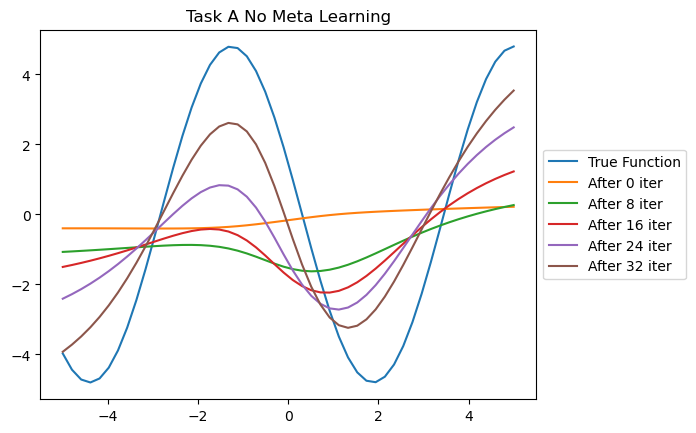

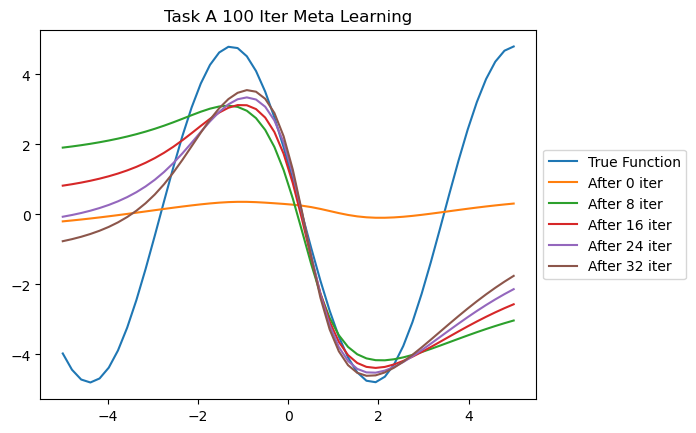

In [13]:
model = mlp()
x_eval, y_eval = task_a()


eval_model_plot(model, x_eval, y_eval, plt_title = "Task A No Meta Learning", num_eval = 32)

reptile_serial(model, 100, task_a, batchsize = 10, reptile_stepsize = 0.1)


eval_model_plot(model, x_eval, y_eval, plt_title = "Task A 100 Iter Meta Learning", num_eval = 32)

